In [2]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm

In [3]:
en_nlp = spacy.load('en_core_web_sm')

In [3]:
data = pd.read_csv('data_before_actors.csv')
data.head()

,tmdb_id,imdb_id,title,revenue,budget,genres,release_date,runtime,tmdb_vote_average,tmdb_vote_count,...,GENRE_Western,GENRE_Horror,GENRE_Documentary,GENRE_War,GENRE_Music,GENRE_TV Movie,GENRE_Film_Noir,GENRE_Biography,GENRE_Sport,GENRE_Musical
0,8095.0,tt0056937,Cleopatra,71000000,44000000.0,"['Drama', 'History', 'Romance']",1963-06-12,248.0,7.0,438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20367.0,tt0037638,Detour,16172,30000.0,"['Crime', 'Drama']",1945-11-30,67.0,7.2,201,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11620.0,tt0043949,Quo Vadis,101486,7623000.0,"['Drama', 'History', 'Romance']",1951-11-08,171.0,7.0,246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10865.0,tt0230011,Atlantis: The Lost Empire,186053725,120000000.0,"['Animation', 'Family', 'Adventure', 'Science ...",2001-06-02,95.0,6.9,3494,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11313.0,tt0252501,Hearts in Atlantis,24185781,31000000.0,"['Drama', 'Mystery']",2001-09-07,101.0,6.5,319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
blurb = data.blurb.copy()
blurb.head(20)

0     Determined to hold on to the throne, Cleopatra...
1     Al Roberts, a New York nightclub pianist, hitc...
2     Set against the back drop of Rome in crisis, G...
3     The world's most highly qualified crew of arch...
4     A widowed mother and her son change when a mys...
5     When her father unexpectedly passes away, youn...
6     Routinely exploited by her wicked stepmother, ...
7     The true story of boxer Jim Braddock who, in t...
8     To prevent a world war from breaking out, famo...
9     Alice, an unpretentious and individual 19-year...
10    Nat Turner, a former slave in America, leads a...
11    A venal, spoiled stockbroker's wife impulsivel...
12    Outlaw Jesse James is rumored to be the 'faste...
13    Charlie Croker pulled off the crime of a lifet...
14    Six years after the events of The X-Files seri...
15    A young man is in a race against time as he se...
16    A vampire relates his epic life story of love,...
17    A ship sent to investigate a wave of myste

In [6]:
def process_text(documents, pos=False):
    '''
    cleans sentences from stop words and punctuation and filters by pos tags if given
    returns cleaned sentence and tokenized sentence
    '''
    nlp = spacy.load('en_core_web_sm')
    
    texts = []
    tokenised_texts = []

    if pos: # pos can either be False or a list of parts of speech
        for document in tqdm(nlp.pipe(documents, batch_size=200)):
            assert document.is_parsed
            tokens = [token
                      for token in document 
                      if token.is_stop == False
                      and token.pos_ in pos
                      and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
    
    
    else:    
        for document in tqdm(nlp.pipe(documents, batch_size=200)):
            assert document.is_parsed
            tokens = [token
                      for token in document 
                      if token.is_stop == False
                      and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
            
    return texts, tokenised_texts

In [14]:
#change null values to blank sentences so that spacy can recognise the null value as a sentence
processed_quotes, tokenised_quotes = process_text(data.blurb.replace(np.nan , '.'), pos=False)

9537it [00:51, 186.92it/s]


In [18]:
data['tokenized_blurbs'] = tokenised_quotes

In [49]:
data.blurb.isnull().sum()

24

creation of the sentiment dictionary, filled with words, thier position of speech and their sentiment scores (positive and negative)

In [7]:
sen = pd.read_csv('file:///Users/chrismembrey/Desktop/GA/DSI16-lessons/week09/day5_nlp%20class/sentiment-analysis-lesson/datasets/sentiment_words_simple.csv')
sen.pos = sen.pos.map(lambda x: x.upper())
sen.pos.unique()

array(['ADJ', 'NOUN', 'ADV', 'VERB'], dtype=object)

In [8]:
sen['objectivity'] = 1. - (sen.pos_score + sen.neg_score)
sen['pos_vs_neg'] = sen.pos_score - sen.neg_score

In [9]:
from collections import defaultdict
sen_dict = defaultdict(dict) # set up a default dictionary with an empty dictionary as default value

for row in tqdm(sen.itertuples()):
    sen_dict[row.pos] [row.word] = {'objectivity': row.objectivity, 'pos_vs_neg': row.pos_vs_neg}

155287it [00:00, 645056.74it/s]


In [19]:
def scorer(parsed):
    """
    Determines the average objectivity and positive-versus-negative scores 
    for a given sentence using tokenized corpuses
    """
   
    obj_scores, pvn_scores = [], []
    for token in parsed:
        try:
            obj_scores.append(sen_dict[token.pos_][token.lemma_]['objectivity'])
            pvn_scores.append(sen_dict[token.pos_][token.lemma_]['pos_vs_neg'])
        except:
            pass
        
    # set default values if no token found
    if not obj_scores:
        obj_scores = [0.5]
    if not pvn_scores:
        pvn_scores = [0.]
        
    return [np.mean(obj_scores), np.mean(pvn_scores)]

In [20]:
scores = data['tokenized_blurbs'].map(scorer)
data['objectivity_avg'] = scores.map(lambda x: x[0])
data['polarity_avg'] = scores.map(lambda x: x[1])

correlations of the objectivity and polarity with ROI

In [21]:
data[['ROI', 'objectivity_avg', 'polarity_avg']].corr()

,ROI,objectivity_avg,polarity_avg
ROI,1.00000,-0.022210,-0.016530
objectivity_avg,-0.02221,1.000000,0.142161
polarity_avg,-0.01653,0.142161,1.000000


In [22]:
data[['ROI', 'objectivity_avg', 'polarity_avg', 'tokenized_blurbs']]

,ROI,objectivity_avg,polarity_avg,tokenized_blurbs
0,61.363636,0.903075,0.000992,"[Determined, hold, throne, Cleopatra, seduces,..."
1,-46.093333,0.898970,0.012065,"[Al, Roberts, New, York, nightclub, pianist, h..."
2,-98.668687,0.814066,-0.071299,"[Set, drop, Rome, crisis, General, Marcus, Vin..."
3,55.044771,0.925194,0.005663,"[world, highly, qualified, crew, archaeologist..."
4,-21.981352,0.836830,-0.043080,"[widowed, mother, son, change, mysterious, str..."
...,...,...,...,...
9532,-9.966182,0.918519,0.021296,"[woman, island, getaway, boyfriend, thrown, lo..."
9533,4.347826,0.816759,0.014545,"[thrown, home, wife, promiscuous, Mark, finds,..."
9534,-29.741054,0.916422,-0.000774,"[high, school, boy, run, away, Tokyo, befriend..."
9535,-17.762325,0.857858,0.070267,"[true, life, story, Christian, music, star, Je..."


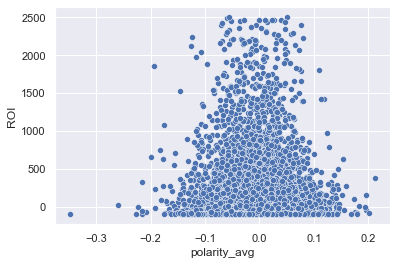

In [37]:
sns.scatterplot(y = data.ROI , x = data['polarity_avg']);

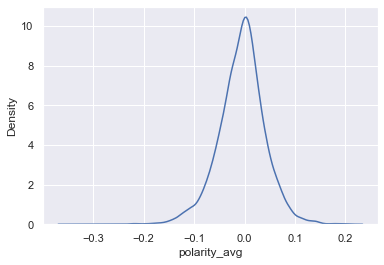

In [38]:
sns.kdeplot(data['polarity_avg']);

We can see that the polarity is normally distributed and centred around 0.

In [27]:
data.to_csv('blurb_analysis.csv')

<b> Does vader sentiment analysis change the result? </b>

In [7]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

In [31]:
vader_scores = data['blurb'].replace(np.nan,'').map(vader.polarity_scores)

In [32]:
from sklearn.feature_extraction import DictVectorizer

dvec = DictVectorizer()

vader_scores = dvec.fit_transform(vader_scores)
vader_scores

for i, col in enumerate(dvec.feature_names_):
    data['vader_{}'.format(col)] = vader_scores[:, i].toarray().ravel()

In [33]:
dvec.feature_names_

['compound', 'neg', 'neu', 'pos']

In [35]:
data[['vader_compound', 'vader_neg', 'vader_neu' , 'vader_pos', 'ROI']].corr()

,vader_compound,vader_neg,vader_neu,vader_pos,ROI
vader_compound,1.000000,-0.724097,0.077181,0.694890,-0.003077
vader_neg,-0.724097,1.000000,-0.601460,-0.253038,0.015467
vader_neu,0.077181,-0.601460,1.000000,-0.501782,-0.013092
vader_pos,0.694890,-0.253038,-0.501782,1.000000,0.012634
ROI,-0.003077,0.015467,-0.013092,0.012634,1.000000


<b> Very similar results to the spacy sentiment </b>